<a href="https://ai4life-mdc24.grand-challenge.org/ai4life-mdc24/">
    <img src="https://rumc-gcorg-p-public.s3.amazonaws.com/b/756/denoising.x10.jpeg" height="200" />
</a>

# JUMP dataset

In [34]:
# Imports necessary to execute the code


import os
os.chdir("D:/Homework/project/")  
print(os.getcwd())
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pooch
import tifffile
from careamics import CAREamist
from careamics.config import create_n2v_configuration
import torch

# use n2v2
use_n2v2 = False

# folder in which to save all the data
root = Path("jump")
# print(root)

D:\Homework\project


## Import the dataset

In [11]:
# download the data using pooch
# data_root = root / "data"
# dataset_url = "https://zenodo.org/records/10912386/files/noisy.tiff"

# file = pooch.retrieve(
#     url=dataset_url,
#     known_hash="394541cd10b5f10cc929e8083e42f757e47eb0a318cf78448a9e4622179c3069",
#     path=data_root,
# )

## Visualize data

Image shape: (517, 4, 540, 540)


Text(0.5, 1.0, 'Channel 4')

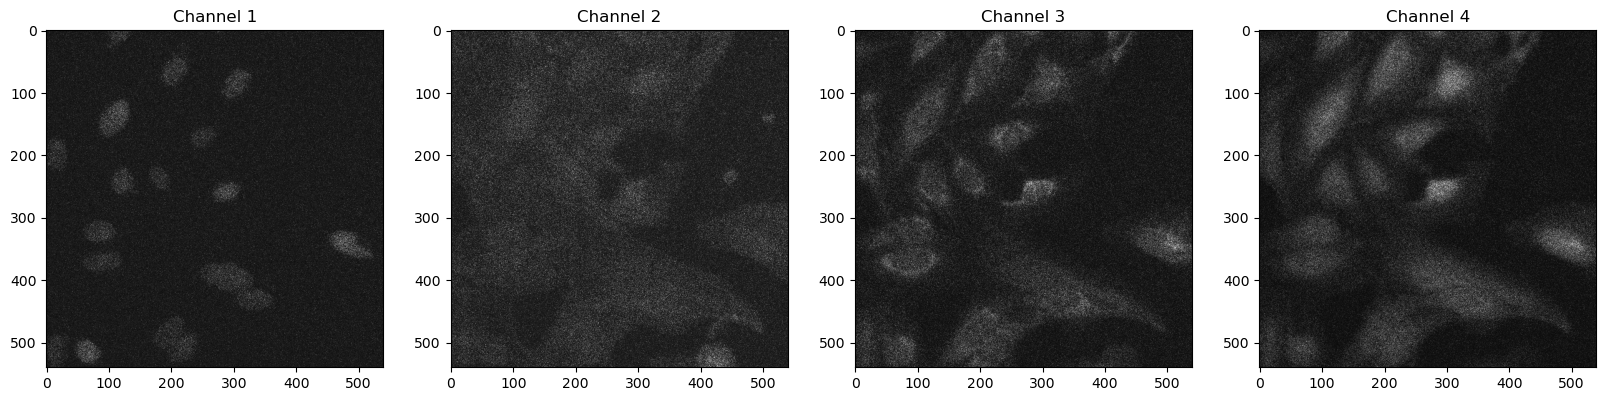

In [20]:
# load training and validation image and show them side by side
train_image = tifffile.imread(r'D:\Homework\project\jump\data\22125685f24e39a69900bc5be41548aa-noisy.tiff')
print(f"Image shape: {train_image.shape}")

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(train_image[0][0], cmap="gray")
ax[0].set_title("Channel 1")
ax[1].imshow(train_image[0][1], cmap="gray")
ax[1].set_title("Channel 2")
ax[2].imshow(train_image[0][2], cmap="gray")
ax[2].set_title("Channel 3")
ax[3].imshow(train_image[0][3], cmap="gray")
ax[3].set_title("Channel 4")

## Train with CAREamics

### Create configuration


In [13]:
# create configuration
algo = "n2v2" if use_n2v2 else "n2v"

config = create_n2v_configuration(
    experiment_name="jump_" + algo,
    data_type="array",
    axes="SCYX",
    patch_size=(64, 64),
    batch_size=32,
    num_epochs=15,
    n_channels=4,
    use_n2v2=use_n2v2,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 4,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 4},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'SCYX',
                 'batch_size': 32,
                 'data_type': 'array',
                 'patch_size': [64, 64],
                 'train_dataloader_params': {'shuffl

### Train

In [15]:
# instantiate a CAREamist
careamist = CAREamist(
    source=config,
    work_dir=root / algo,
)

# train
careamist.train(
    train_source=train_image,
    val_percentage=0.0,
    val_minimum_split=10,  # use 10 patches as validation
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 2.0 M  | train
---------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.147     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


## Predict 

In [16]:
prediction = careamist.predict(
    source=train_image,
    tile_size=(256, 256),
    tile_overlap=(48, 48),
    batch_size=1,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

### Save predictions

In [17]:
pred_folder = root / ("results_" + algo)
pred_folder.mkdir(exist_ok=True, parents=True)

final_data = np.concatenate(prediction)
tifffile.imwrite(pred_folder / "prediction.tiff", final_data)

### Visualize the prediction

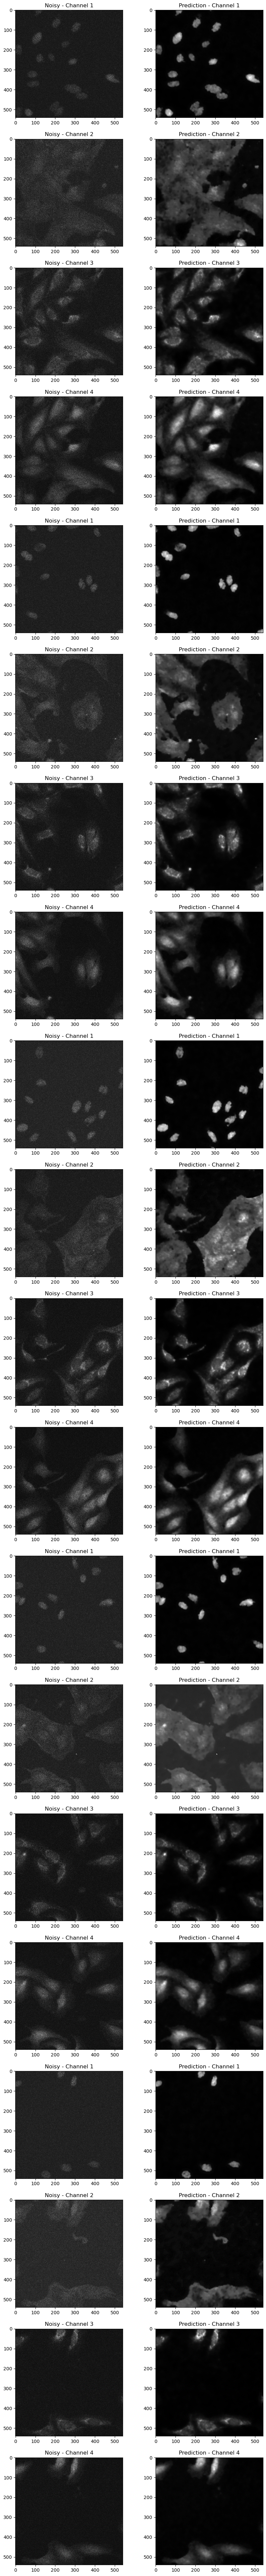

In [18]:
n = 5

fig, ax = plt.subplots(4 * n, 2, figsize=(10, 4 * n * 5))
for i in range(n):
    row = 4 * i

    # channel 1
    ax[row, 0].imshow(train_image[i, 0], cmap="gray")
    ax[row, 0].set_title("Noisy - Channel 1")
    ax[row, 1].imshow(prediction[i].squeeze()[0], cmap="gray")
    ax[row, 1].set_title("Prediction - Channel 1")

    # channel 2
    ax[row + 1, 0].imshow(train_image[i, 1], cmap="gray")
    ax[row + 1, 0].set_title("Noisy - Channel 2")
    ax[row + 1, 1].imshow(prediction[i].squeeze()[1], cmap="gray")
    ax[row + 1, 1].set_title("Prediction - Channel 2")

    # channel 3
    ax[row + 2, 0].imshow(train_image[i, 2], cmap="gray")
    ax[row + 2, 0].set_title("Noisy - Channel 3")
    ax[row + 2, 1].imshow(prediction[i].squeeze()[2], cmap="gray")
    ax[row + 2, 1].set_title("Prediction - Channel 3")

    # channel 4
    ax[row + 3, 0].imshow(train_image[i, 3], cmap="gray")
    ax[row + 3, 0].set_title("Noisy - Channel 4")
    ax[row + 3, 1].imshow(prediction[i].squeeze()[3], cmap="gray")
    ax[row + 3, 1].set_title("Prediction - Channel 4")

In [ ]:
prediction = np.concatenate(prediction, axis=0)

## Compute metrics

In [ ]:

import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from pytorch_msssim import ms_ssim


def scale_invariant_psnr(gt, pred, data_range=1.0):
    numerator = np.sum(gt * pred)
    denominator = np.sum(pred ** 2)

    if denominator < 1e-12:
        alpha = 0.0
    else:
        alpha = numerator / denominator

    scaled_pred = alpha * pred
    mse = np.mean((gt - scaled_pred) ** 2)

    if mse < 1e-12:
        return 100.0

    sip = 10 * np.log10((data_range ** 2) / mse)
    return sip


def calculate_metrics(train_image, prediction, data_range=22.0):

    psnr_list = []
    sipsnr_list = []
    ssim_list = []
    msssim_list = []

    N, C, H, W = train_image.shape

    for i in range(N):
        for c in range(C):
            gt = train_image[i, c]            # shape: (H, W)
            pred = prediction[i, c]          # shape: (H, W)

            p = peak_signal_noise_ratio(gt, pred, data_range=data_range)
            psnr_list.append(p)

            sp = scale_invariant_psnr(gt, pred, data_range=data_range)
            sipsnr_list.append(sp)

            s = structural_similarity(gt, pred, data_range=data_range)
            ssim_list.append(s)

            gt_ms = np.expand_dims(gt, axis=0)  # shape: (1, H, W)
            gt_ms = torch.tensor(np.expand_dims(gt_ms, axis=0))
            pred_ms = np.expand_dims(pred, axis=0)  # shape: (1, H, W)
            pred_ms = torch.tensor(np.expand_dims(pred_ms, axis=0))
            
            ms = ms_ssim(gt_ms, pred_ms, data_range=data_range)
            msssim_list.append(ms)

    metrics = {
        'PSNR':     np.mean(psnr_list),
        'SIPSNR':   np.mean(sipsnr_list),
        'SSIM':     np.mean(ssim_list),
        'MS-SSIM':  np.mean(msssim_list),
    }
    return metrics

metrics_dict = calculate_metrics(train_image, prediction, data_range=22.0)
print("PSNR:   ", metrics_dict['PSNR'])
print("SIPSNR: ", metrics_dict['SIPSNR'])
print("SSIM:   ", metrics_dict['SSIM'])
print("MS-SSIM:", metrics_dict['MS-SSIM'])


PSNR:    29.491556513696672
SIPSNR:  29.49368268720686
SSIM:    0.5071595720903695
MS-SSIM: 0.89531606


## Create cover

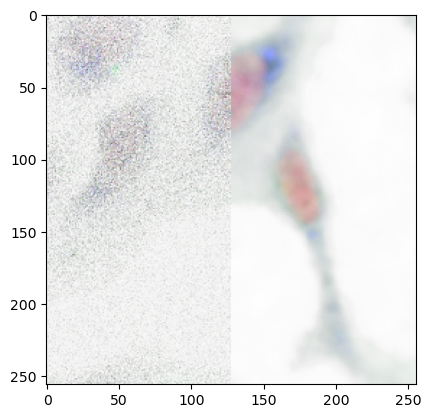

In [19]:
# create a cover image
im_idx = 9
cv_image_noisy = train_image[im_idx]
cv_image_pred = prediction[im_idx].squeeze()

# create image
cover = np.zeros((4, 256, 256))
(_, height, width) = cv_image_noisy.shape
assert height > 256
assert width > 256

# get min and max and reshape them so that they can be broadcasted with the images
noise_min = np.array(np.min(cv_image_noisy, axis=(1, 2)))[
    (..., *[np.newaxis] * (cv_image_noisy.ndim - 1))
]
noise_max = np.array(np.max(cv_image_noisy, axis=(1, 2)))[
    (..., *[np.newaxis] * (cv_image_noisy.ndim - 1))
]
pred_min = np.array(np.min(cv_image_pred, axis=(1, 2)))[
    (..., *[np.newaxis] * (cv_image_pred.ndim - 1))
]
pred_max = np.array(np.max(cv_image_pred, axis=(1, 2)))[
    (..., *[np.newaxis] * (cv_image_pred.ndim - 1))
]

# normalize train and prediction per channel
norm_noise = (cv_image_noisy - noise_min) / (noise_max - noise_min)
norm_pred = (cv_image_pred - pred_min) / (pred_max - pred_min)

# fill in halves
cover[:, :, : 256 // 2] = norm_noise[
    :,
    height // 2 - 256 // 2 : height // 2 + 256 // 2,
    width // 2 - 256 // 2 : width // 2,
]
cover[:, :, 256 // 2 :] = norm_pred[
    :,
    height // 2 - 256 // 2 : height // 2 + 256 // 2,
    width // 2 : width // 2 + 256 // 2,
]

# move C axis at the end
cover = np.moveaxis(cover, 0, -1)

# plot the single image
plt.imshow(cover)

# save the image
plt.imsave("JUMP_N2V.jpeg", cover)